In [4]:
# %%

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import tables
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from optparse import OptionParser
from matplotlib.colors import LogNorm,Normalize
from pylab import *
from scipy.interpolate import interp1d, UnivariateSpline
import glob

# %%
name_nu_1 = []


# %% add the input file path here
#name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuE_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file full sim
name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file full sim

#name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau_CSMS_1_2.h5') # my file full sim
#name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file NuGeN Only

### YX files
#name_nu_1 = glob.glob('/data/user/joanna/CSecGen-Data/100_v4/nugen_nodetector_nutau_100_50*.h5') #YX file


# %%
name_nu_1  =name_nu_1[:1]


# %%
len(name_nu_1)

# %%
NFiles_nu_1 =  2000.*np.ones(1)

# %%


pdist = lambda p1, p2 : ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def weight_cal(f,fit,NFiles,livetime,selfveto):
    if fit == 0:
        index=-2
        norm_astro=1
        norm_conv=1
        norm_prompt=1
    elif fit == 2:
        index=-2.67
        norm_astro=2.15
        norm_conv=0.84
        norm_prompt=0.47
    elif fit == 1:
        index = -2.73
        norm_astro=2.2
        norm_conv=0.85
        norm_prompt=0.3
    elif fit == 8:
        index = -2.48
        norm_astro = 1.61
        norm_conv = 1.06
        norm_prompt = 1.

    OneWeight=f.root.I3MCWeightDict.col('OneWeight')
    NEvents=f.root.I3MCWeightDict.col('NEvents')
    PrimaryNeutrinoEnergy=f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy')
    print('NEvents=',NEvents)
    print('NFiles=',NFiles)

    
    astro_weight = OneWeight/(NEvents*NFiles)*1.0e-18*np.power(PrimaryNeutrinoEnergy/100000,index)*norm_astro*livetime
    return astro_weight


class variable:
    def __init__(self,f,year,NFiles):
        self.f=f
        self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalXsectionCGS')*1.0e27) #converting xsec unit from cm^2 to mb
        #self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalCrosssectionCGS')*1.0e27) #converting xsec unit from cm^2 to mb #YX files
        #self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalXsectionCGS')*1.0e27)
        fit = 8
        #livetime = 1.0*3600*24*365*5
        #livetime = 1.0
        livetime = 1.0*(31.04*3600*24+3156904+2820269+2909466+2966167)
        #self.weight_wo_sv=weight_cal(self.f,fit,NFiles,livetime,0)
        self.weight=weight_cal(self.f,fit,NFiles,livetime,0)


        self.zenith = np.cos(f.root.I3MCWeightDict.col('PrimaryNeutrinoZenith'))
        #self.inice_primary_energy = np.log10(f.root.cscdSBU_MCInIcePrimary.col('energy')) #YX files
        self.inice_primary_energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
        self.primary_energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
        self.diff = (np.power(10,self.primary_energy)-np.power(10,self.inice_primary_energy))/np.power(10,self.primary_energy)*100.0
        #self.prop=f.root.I3MCWeightDict.col('TotalPropagationProbability')
        #self.prop=f.root.I3MCWeightDict.col('PropagationWeight')
        #self.type= f.root.I3MCWeightDict.col('PrimaryNeutrinoType')
        #self.inter_type = f.root.I3MCWeightDict.col('InteractionType')
        #self.energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
    

def selection(sample):
    #idx = sample.zenith > -100
    idx = np.isfinite(sample.xsec)
    idx = np.logical_and(idx,np.logical_not(np.isnan(sample.zenith)))
    idx = np.logical_and(idx,np.logical_not(np.isnan(sample.primary_energy)))
    idx = np.logical_and(idx,np.logical_not(np.isnan(sample.inice_primary_energy)))
    idx = np.logical_and(idx,np.logical_not(np.isnan(sample.weight)))
    return idx


seperation = 0.

function = selection

nu_1_inice=[]
nu_1_zenith=[]
nu_1_weight=[]
nu_1_diff=[]
nu_1_prim=[]
nu_1_xsec=[]



for file, nfiles in zip(name_nu_1,NFiles_nu_1):
    file_nu = tables.open_file(file)
    v_nu = variable(file_nu,2011,nfiles)
    idx_nu = function(v_nu)
    nu_1_inice = np.concatenate((nu_1_inice,v_nu.inice_primary_energy[idx_nu]))
    nu_1_zenith = np.concatenate((nu_1_zenith,v_nu.zenith[idx_nu]))
    nu_1_weight = np.concatenate((nu_1_weight,v_nu.weight[idx_nu]))
    nu_1_diff = np.concatenate((nu_1_diff,v_nu.diff[idx_nu]))
    nu_1_prim = np.concatenate((nu_1_prim,v_nu.primary_energy[idx_nu]))
    nu_1_xsec = np.concatenate((nu_1_xsec,v_nu.xsec[idx_nu]))
    file_nu.close()

# %%
print('number of raw events:',len(nu_1_zenith))
idx_nu_1_up = nu_1_zenith<seperation
idx_nu_1_down = nu_1_zenith>=seperation

inice_1_up = nu_1_inice[idx_nu_1_up]
inice_1_down = nu_1_inice[idx_nu_1_down]

weight_1_up = nu_1_weight[idx_nu_1_up]
weight_1_down = nu_1_weight[idx_nu_1_down]

xsec_1_up = nu_1_xsec[idx_nu_1_up]
xsec_1_down = nu_1_xsec[idx_nu_1_down]

diff_1_up = nu_1_diff[idx_nu_1_up]
diff_1_down = nu_1_diff[idx_nu_1_down]


prim_1_up = nu_1_prim[idx_nu_1_up]
prim_1_down = nu_1_prim[idx_nu_1_down]




/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10


NEvents= [1000000. 1000000. 1000000. ... 1000000. 1000000. 1000000.]
NFiles= 2000.0
number of raw events: 999998


In [25]:
len(prim_1_down)

499745

In [5]:
import matplotlib.pyplot as plt


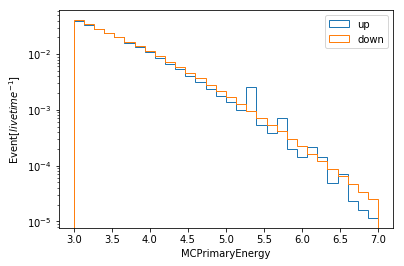

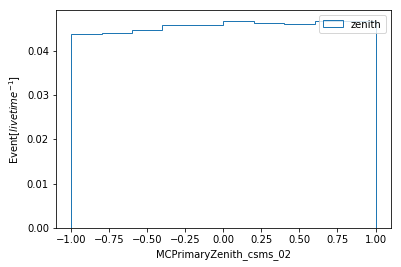

<Figure size 432x288 with 0 Axes>

In [6]:
plt.hist(prim_1_up,weights=weight_1_up,bins=30,histtype='step',label='up')
plt.hist(prim_1_down,weights=weight_1_down,bins=30,histtype='step',label='down')
plt.legend() 
plt.yscale('log')
plt.xlabel('MCPrimaryEnergy')
plt.ylabel(r'Event[$livetime^{-1}$]')

plt.show()
plt.savefig('Nutau_Energy_csms_1.png')
plt.close()
plt.hist(nu_1_zenith,weights=nu_1_weight,histtype='step',label='zenith')
plt.legend()
plt.xlabel('MCPrimaryZenith_csms_02')
plt.ylabel(r'Event[$livetime^{-1}$]')
plt.show()
plt.savefig('Nutau_Zenith_csms_1.png')

In [37]:
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
def histerror(x,w,nbins,histtitle,c):
    data = x
    weights = w
    entries, bin_edges = np.histogram(data,weights=w,bins=nbins)

    #bin_edges = [0.0, 2.5, 5.0, 7.5, 10.0]

    bin_y, _, bars = plt.hist(data, bins=bin_edges, weights=weights,histtype='step',label=histtitle,color=c)
    #print(f"bin_y {bin_y}")
    #print(f"bin_edges {bin_edges}")

    errors = []
    bin_centers = []

    for bin_index in range(len(bin_edges) - 1):
        # find which data points are inside this bin
        bin_left = bin_edges[bin_index]
        bin_right = bin_edges[bin_index + 1]
        in_bin = np.logical_and(bin_left < data, data <= bin_right)
        #print(f"in_bin {in_bin}")

        # filter the weights to only those inside the bin
        weights_in_bin = weights[in_bin]
        #print(f"weights_in_bin {weights_in_bin}")

        # compute the error however you want
        error = np.sqrt(np.sum(weights_in_bin ** 2))
        errors.append(error)
        #print(f"error {error}")
        # save the center of the bins to plot the errorbar in the right place
        bin_center = (bin_right + bin_left) / 2
        bin_centers.append(bin_center)
        #print(f"bin_center {bin_center}")

    # plot the error bars
    #len(bin_centers)
    plt.errorbar(bin_centers, bin_y, yerr=errors,color=c, capsize=3 ,linestyle="none")
    plt.legend()


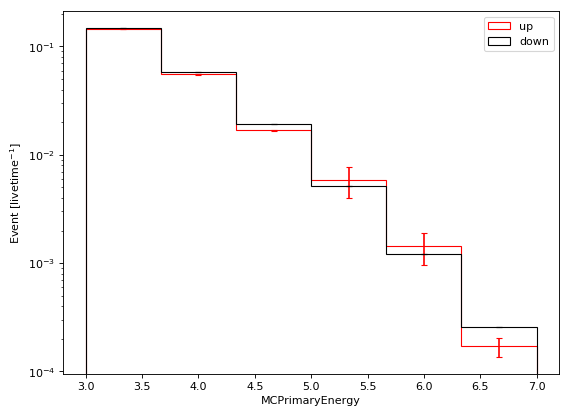

In [48]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
histerror(prim_1_up,weight_1_up,6,'up','red')
histerror(prim_1_down,weight_1_down,6,'down','black')

plt.ylabel(r'$\rm Event\ [livetime^{-1}]$')
plt.xlabel('MCPrimaryEnergy')
plt.yscale('log')


In [ ]:
/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_020_FullnoGR.h5